In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
import torch as th

In [3]:
from chromalab.observer import Observer, Cone
from chromalab.inks import Neugebauer, InkGamut, CellNeugebauer, Pigment
from chromalab.spectra import Spectra, Illuminant

In [4]:
from chromalab.inks import InkLibrary

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
wavelengths4 = np.arange(380, 781, 4)
wavelengths1 = np.arange(390, 701, 1)
wavelengths10 = np.arange(400, 701, 10)

In [7]:
elevator_illuminant = Spectra(data=np.load("../data/illuminants/elevator.npy"), wavelengths=wavelengths4)

In [9]:
tetrachromat_elevator = Observer.tetrachromat(wavelengths=wavelengths10,illuminant=elevator_illuminant)

## best mets from measures

In [10]:
pairs = {}
with open(f'../data/nix/Pairs415.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue
            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
    
        pairs[name]  = spectra

In [15]:
def compare(s1, s2):
    d1 = tetrachromat_elevator.observe(s1)
    d2 = tetrachromat_elevator.observe(s2)
    d1[2] = 0
    d2[2] = 0
    return np.sum(np.square(d1 - d2))

In [28]:
def compare3(s1, s2):
    d1 = tetrachromat_elevator.observe(s1)
    d2 = tetrachromat_elevator.observe(s2)
    c = d1[2] + d2[2]
    d1[2] = 0
    d2[2] = 0
    return np.sum(np.square(d1 - d2)) / c

In [29]:
k = len(pairs)
keys = list(pairs.keys())
scores3 = []
for i in range(0, k, 2):
    for j in range(1, k, 2):
        score = compare3(pairs[keys[i]], pairs[keys[j]])
        scores3.append((score, (keys[i], keys[j])))

In [31]:
scores3.sort()
scores3

[(2.0610109051371893e-05, ('23:25,32,47,85', '37:37,90,2,50')),
 (2.2451630213666327e-05, ('19:27,2,57,85', '31:42,95,2,17')),
 (2.2675601509058744e-05, ('7:30,22,50,90', '20:42,95,0,52')),
 (4.27446059895488e-05, ('39:22,5,55,87', '37:37,90,2,50')),
 (4.4395266984092574e-05, ('46:22,0,57,92', '38:37,92,2,65')),
 (4.5961918526295276e-05, ('8:30,20,52,90', '20:42,95,0,52')),
 (5.3052613440871897e-05, ('6:30,25,47,90', '42:37,90,2,62')),
 (6.6713455505985236e-05, ('19:27,2,57,85', '18:42,95,5,27')),
 (6.8975894111251979e-05, ('9:30,17,50,92', '24:40,97,0,50')),
 (7.5171535649849755e-05, ('9:30,17,50,92', '40:40,97,2,47')),
 (7.597540904494866e-05, ('46:22,0,57,92', '42:37,90,2,62')),
 (9.3547487129406912e-05, ('12:30,7,52,95', '29:40,97,5,67')),
 (9.983298313034775e-05, ('7:30,22,50,90', '48:40,97,2,37')),
 (0.00010075976353179537, ('4:32,15,52,80', '27:42,92,0,7')),
 (0.00012559973107171879, ('22:25,40,47,80', '32:40,87,0,45')),
 (0.00012826553517917714, ('18:27,5,50,85', '32:40,87,0,45

### best mets black bodies

In [37]:
import math

In [38]:
PLANCK_CONSTANT   = 6.6237e-34      # J-sec
SPEED_OF_LIGHT    = 2.997925e+08    # m/sec
BOLTZMAN_CONSTANT = 1.3802e-23      # J/K
SUN_TEMPERATURE   = 5778.0          # K

In [39]:
start_wl_nm = 360
end_wl_nm   = 830
delta_wl_nm = 1.0

In [40]:
def empty_spectrum ():
    '''Get a black (no intensity) ColorPy spectrum.

    This is a 2D numpy array, with one row for each wavelength in the visible range,
    360 nm to 830 nm, with a spacing of delta_wl_nm (1.0 nm), and two columns.
    The first column is filled with the wavelength [nm].
    The second column is filled with 0.0.  It should later be filled with the intensity.

    The result can be passed to xyz_from_spectrum() to convert to an xyz color.
    '''
    wl_nm_range = range (start_wl_nm, end_wl_nm + 1)
    num_wl = len (wl_nm_range)
    spectrum = np.zeros ((num_wl, 2))
    for i in range (0, num_wl):
        spectrum [i][0] = float (wl_nm_range [i])
    return spectrum

In [41]:
def blackbody_specific_intensity (wl_nm, T_K):
    '''Get the monochromatic specific intensity for a blackbody -
        wl_nm = wavelength [nm]
        T_K   = temperature [K]
    This is the energy radiated per second per unit wavelength per unit solid angle.
    Reference - Shu, eq. 4.6, p. 78.'''
    # precalculations that could be made global
    a = (PLANCK_CONSTANT * SPEED_OF_LIGHT) / (BOLTZMAN_CONSTANT)
    b = (2.0 * PLANCK_CONSTANT * SPEED_OF_LIGHT * SPEED_OF_LIGHT)
    wl_m = wl_nm * 1.0e-9
    inv_exponent = (wl_m * T_K) / a
    # Very large exponents (small inv_exponent) result in nearly zero intensity.
    # Avoid the numeric troubles in this case and return zero intensity.
    if inv_exponent < 1.0 / 500.0:
        return 0.0
    exponent = 1.0 / inv_exponent
    specific_intensity = b / (math.pow (wl_m, 5) * (math.exp (exponent) - 1.0))
    return specific_intensity

def blackbody_spectrum (T_K):
    '''Get the spectrum of a blackbody, as a numpy array.'''
    spectrum = empty_spectrum()
    num_wl = spectrum.shape[0]
    for i in range (0, num_wl):
        # Intensity per unit wavelength.
        specific_intensity = blackbody_specific_intensity (spectrum [i][0], T_K)
        # Scale by size of wavelength interval.
        spectrum [i][1] = specific_intensity * delta_wl_nm * 1.0e-9
    return spectrum

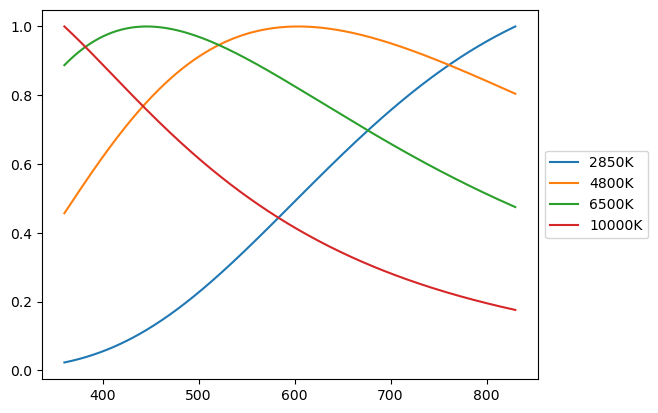

In [42]:
radiators = {}
for t in [2850, 4800, 6500, 10000]:
    radiator = ~(Spectra(blackbody_spectrum(t), normalized=False))
    radiator.plot(f"{t}K")
    radiators[t] = radiator
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [43]:
def compare_ill(s1, s2, illuminant):
    tet = Observer.tetrachromat(illuminant=illuminant)
    d1 = tet.observe(s1)
    d2 = tet.observe(s2)
    c = d1[2] + d2[2]
    d1[2] = 0
    d2[2] = 0
    return np.sum(np.square(d1 - d2)) / c

In [49]:
from tqdm.notebook import tqdm

In [48]:
scores4 = []
for i in tqdm(range(0, k, 2)):
    for j in range(1, k, 2):
        score = compare_ill(pairs[keys[i]], pairs[keys[j]], radiators[2850])
        scores4.append((score, (keys[i], keys[j])))

In [52]:
scores4.sort()
scores4[:3]

[(4.0066189909385369e-05, ('6:30,25,47,90', '37:37,90,2,50')),
 (4.1327071006768735e-05, ('15:27,15,52,82', '43:40,87,0,25')),
 (4.2244524456378544e-05, ('12:30,7,52,95', '24:40,97,0,50'))]

In [53]:
scores5 = []
for i in tqdm(range(0, k, 2)):
    for j in range(1, k, 2):
        score = compare_ill(pairs[keys[i]], pairs[keys[j]], radiators[4800])
        scores5.append((score, (keys[i], keys[j])))

  0%|          | 0/49 [00:00<?, ?it/s]

/Users/varun/Documents/Python/ChromaLab/chromalab/spectra.py:35: UserWarning: Data has values not between 0 and 1. Clipping.
  warnings.warn("Data has values not between 0 and 1. Clipping.")


In [59]:
scores5.sort()
scores5[:20]

[(0.00025401356864372253, ('9:30,17,50,92', '42:37,90,2,62')),
 (0.00027744472695315312, ('9:30,17,50,92', '38:37,92,2,65')),
 (0.00032694392124652622, ('3:32,17,50,80', '43:40,87,0,25')),
 (0.00033387792857885595, ('4:32,15,52,80', '44:40,87,0,15')),
 (0.00034239570869695524, ('36:22,12,57,87', '32:40,87,0,45')),
 (0.00034833863648551849, ('17:27,7,55,85', '32:40,87,0,45')),
 (0.00037438479039833409, ('7:30,22,50,90', '42:37,90,2,62')),
 (0.00038728247590755319, ('8:30,20,52,90', '14:42,92,0,50')),
 (0.00038922397483413291, ('25:25,27,47,92', '42:37,90,2,62')),
 (0.00040428831751478886, ('19:27,2,57,85', '43:40,87,0,25')),
 (0.00041582752542973901, ('36:22,12,57,87', '37:37,90,2,50')),
 (0.00043420183772371646, ('3:32,17,50,80', '44:40,87,0,15')),
 (0.0004534903528404742, ('8:30,20,52,90', '42:37,90,2,62')),
 (0.00047213600252188684, ('19:27,2,57,85', '27:42,92,0,7')),
 (0.00047221240879310978, ('7:30,22,50,90', '37:37,90,2,50')),
 (0.0004795062209626961, ('12:30,7,52,95', '47:40,97,0

In [55]:
scores6 = []
for i in tqdm(range(0, k, 2)):
    for j in range(1, k, 2):
        score = compare_ill(pairs[keys[i]], pairs[keys[j]], radiators[6500])
        scores6.append((score, (keys[i], keys[j])))

  0%|          | 0/49 [00:00<?, ?it/s]

/Users/varun/Documents/Python/ChromaLab/chromalab/spectra.py:35: UserWarning: Data has values not between 0 and 1. Clipping.
  warnings.warn("Data has values not between 0 and 1. Clipping.")


In [57]:
scores6.sort()
scores6[:9]

[(0.00042088233848354303, ('9:30,17,50,92', '42:37,90,2,62')),
 (0.00047999673122465586, ('8:30,20,52,90', '42:37,90,2,62')),
 (0.00051214018990732675, ('7:30,22,50,90', '42:37,90,2,62')),
 (0.00052829850059914316, ('19:27,2,57,85', '43:40,87,0,25')),
 (0.0005406242310018269, ('8:30,20,52,90', '37:37,90,2,50')),
 (0.00055976125973022201, ('9:30,17,50,92', '38:37,92,2,65')),
 (0.00057066810123967808, ('7:30,22,50,90', '37:37,90,2,50')),
 (0.00060745515593317557, ('36:22,12,57,87', '32:40,87,0,45')),
 (0.00060821502135491681, ('17:27,7,55,85', '32:40,87,0,45'))]

## printing specific hues

1. generate hues we want to print
2. find metamers for those hues via simulation
3. print a radius "around" each metamer 
4. find what turns out to actually be metameric in practice via nix 

### Generate hues we want to print

In [27]:
cell_primaries = {}
with open(f'../data/nix/11cell.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue
            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
    
        cell_primaries[name]  = spectra

In [32]:
cell_neugebauer = CellNeugebauer(cell_primaries,n=1.8)

In [33]:
gamut = InkGamut(cell_neugebauer, illuminant=elevator_illuminant)

In [78]:
buckets = gamut.get_buckets(tetrachromat_elevator, stepsize=0.1)

Generating point cloud: 1it [00:00, 379.95it/s]
Generating point cloud: 1it [00:00, 372.76it/s]
Generating point cloud: 1it [00:00, 395.84it/s]
Generating point cloud: 1it [00:00, 326.68it/s]
Generating point cloud: 1it [00:00, 398.09it/s]
Generating point cloud: 1it [00:00, 548.85it/s]
Generating point cloud: 1it [00:00, 511.75it/s]
Generating point cloud: 1it [00:00, 413.03it/s]
Generating point cloud: 1it [00:00, 295.58it/s]
Generating point cloud: 1it [00:00, 493.10it/s]
Generating point cloud: 1it [00:00, 340.03it/s]
Generating point cloud: 1it [00:00, 453.14it/s]
Generating point cloud: 1it [00:00, 517.62it/s]
Generating point cloud: 1it [00:00, 330.13it/s]
Generating point cloud: 1it [00:00, 403.41it/s]
Generating point cloud: 1it [00:00, 357.42it/s]


Point cloud generated.


In [79]:
rgbs = []
for i,(d, (p1, p2)) in enumerate(buckets):
    rgbs.append(gamut.get_spectra(p1).to_rgb() * 255)
    if i > 121:
        break

In [80]:
def display_color_patches(rgbs):
    # Number of colors
    num_colors = len(rgbs)
    
    # Determine grid size
    grid_size = int(np.ceil(np.sqrt(num_colors)))
    
    # Create a figure with appropriate size
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size, grid_size))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Loop through the list of RGBs and plot each one
    for i, rgb in enumerate(rgbs):
        # Create a 10x10 pixel array with the given RGB color
        color_array = np.full((10, 10, 3), rgb, dtype=np.uint8)
        
        # Display the color array as an image on the respective subplot
        axes[i].imshow(color_array)
        axes[i].axis('off')
        axes[i].set_title(f'Index {i}', fontsize=8)
    
    # Turn off any extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    # Adjust the spacing and display the plot
    plt.tight_layout()
    plt.show()

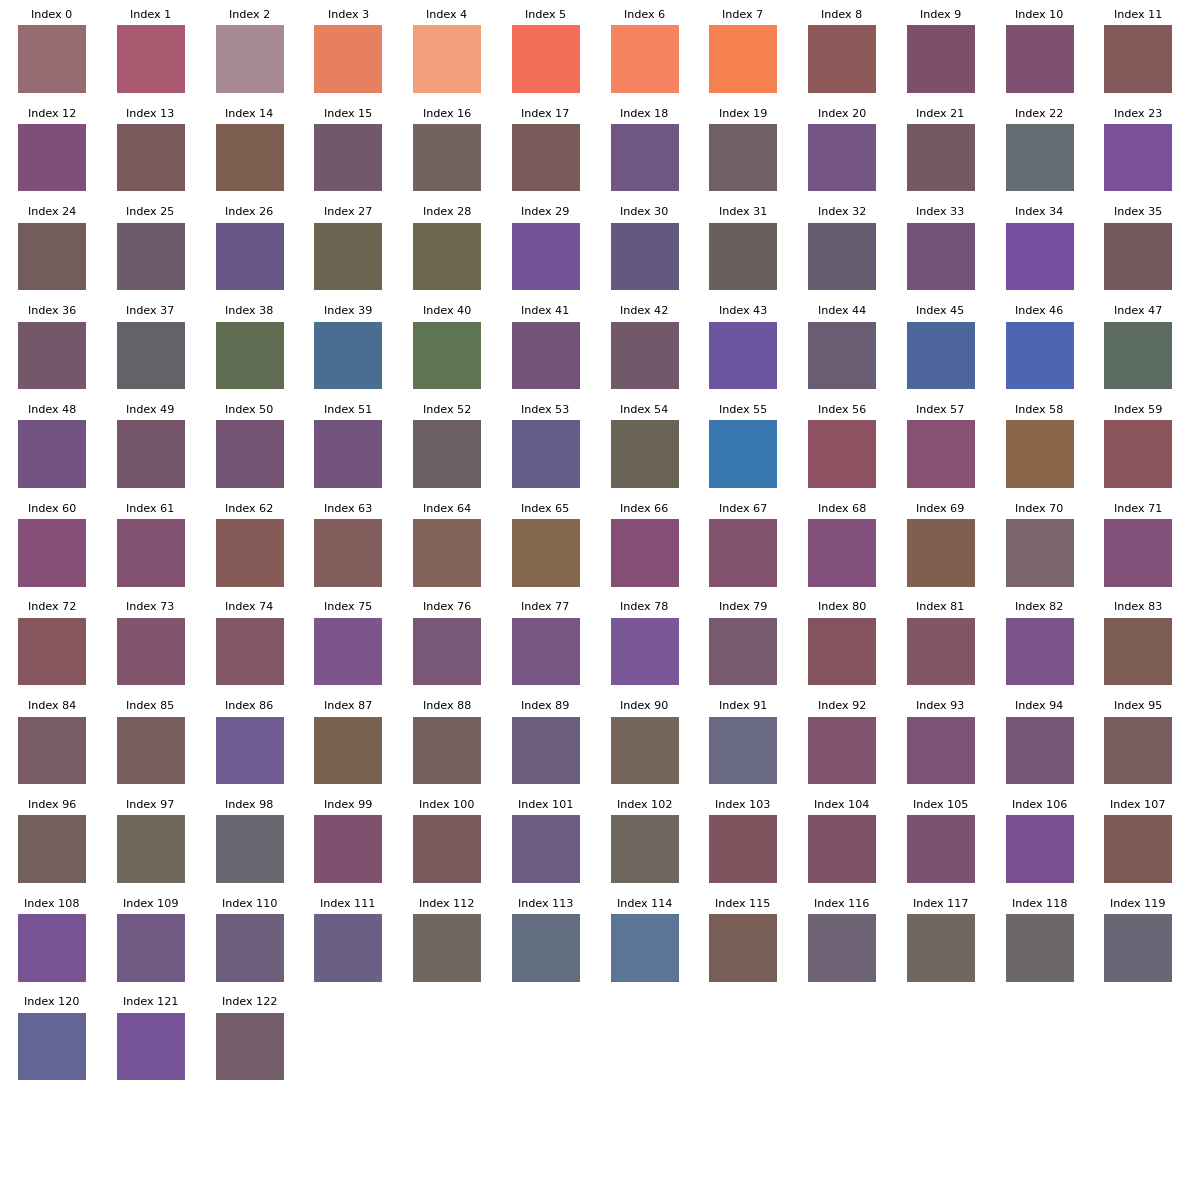

In [81]:
display_color_patches(rgbs)

In [107]:
selected_indices = [0,1,2,3,5,12,19,39,40]

In [108]:
for i in selected_indices:
    print(buckets[i])

(1.0, ((0.5, 0.0, 0.69999999999999996, 0.80000000000000004), (0.80000000000000004, 1.0, 0.0, 0.10000000000000001)))
(1.0, ((0.40000000000000002, 0.5, 0.80000000000000004, 0.69999999999999996), (0.5, 1.0, 0.5, 0.20000000000000001)))
(1.0, ((0.40000000000000002, 0.0, 0.5, 0.59999999999999998), (0.5, 0.69999999999999996, 0.10000000000000001, 0.20000000000000001)))
(1.0, ((0.10000000000000001, 0.30000000000000004, 0.40000000000000002, 0.90000000000000002), (0.30000000000000004, 1.0, 0.0, 0.40000000000000002)))
(1.0, ((0.0, 0.59999999999999998, 0.5, 0.90000000000000002), (0.10000000000000001, 1.0, 0.30000000000000004, 0.59999999999999998)))
(0.5, ((1.0, 0.90000000000000002, 1.0, 0.40000000000000002), (0.80000000000000004, 0.30000000000000004, 1.0, 0.59999999999999998)))
(0.5, ((1.0, 0.80000000000000004, 0.30000000000000004, 0.69999999999999996), (1.0, 0.90000000000000002, 0.20000000000000001, 0.59999999999999998)))
(0.5, ((1.0, 0.30000000000000004, 0.30000000000000004, 0.40000000000000002),

### Find metamers to those hues

can i just use some existing sklearn library bruh

arg,,

In [84]:
from chromalab.inks import get_metamers

In [85]:
pc2, _perc2 = gamut.get_point_cloud(tetrachromat_elevator, stepsize=0.02)

Generating point cloud: 5it [00:00,  5.55it/s]                                                 
Generating point cloud: 5it [00:00,  5.39it/s]                                                 
Generating point cloud: 5it [00:00,  5.80it/s]                                                 
Generating point cloud: 5it [00:00,  5.94it/s]                                                 
Generating point cloud: 5it [00:00,  5.54it/s]                                                 
Generating point cloud: 5it [00:00,  5.94it/s]                                                 
Generating point cloud: 5it [00:00,  5.41it/s]                                                 
Generating point cloud: 5it [00:00,  5.19it/s]                                                 
Generating point cloud: 5it [00:00,  5.16it/s]                                                 
Generating point cloud: 5it [00:00,  5.43it/s]                                                 
Generating point cloud: 5it [00:00,  5.2

In [109]:
metamer_percs = []
for i in tqdm(selected_indices):
    _, (perc1, perc2) = buckets[i]
    stim1 = tetrachromat_elevator.observe(gamut.get_spectra(perc1))
    _, idx1 = get_metamers(pc2, stim1, threshold=0.005)[0]
    stim2 = pc2[idx1]
    _, idx2 = get_metamers(pc2, stim2, threshold=0.005)[0]
    metamer_percs.append(
        (_perc2[idx1], _perc2[idx2])
    )

  0%|          | 0/9 [00:00<?, ?it/s]

In [110]:
metamer_percs

[(array([ 0.78,  1.  ,  0.04,  0.08]), array([ 0.5,  0. ,  0.7,  0.8])),
 (array([ 0.5 ,  0.98,  0.52,  0.26]), array([ 0.36,  0.  ,  0.86,  0.78])),
 (array([ 0.54,  0.76,  0.02,  0.06]), array([ 0.4,  0. ,  0.5,  0.6])),
 (array([ 0.26,  1.  ,  0.06,  0.4 ]), array([ 0.06,  0.06,  0.46,  0.92])),
 (array([ 0.12,  1.  ,  0.28,  0.58]), array([ 0. ,  0.6,  0.5,  0.9])),
 (array([ 0.98,  0.96,  0.8 ,  0.3 ]), array([ 0.82,  0.12,  1.  ,  0.62])),
 (array([ 0.96,  0.06,  0.74,  0.86]), array([ 1. ,  0.8,  0.3,  0.7])),
 (array([ 0.98,  0.04,  0.48,  0.48]), array([ 1.  ,  0.48,  0.22,  0.32])),
 (array([ 1.  ,  0.36,  0.02,  1.  ]), array([ 1. ,  0.3,  0.1,  1. ]))]

### Print radius around each metamer

In [104]:
def sample_points_4d(center, radius, num_samples):
    phi1 = np.random.uniform(0, 2 * np.pi, num_samples)
    phi2 = np.random.uniform(0, 2 * np.pi, num_samples)
    phi3 = np.random.uniform(0, 2 * np.pi, num_samples)
    r = np.random.uniform(0, radius, num_samples) ** 0.25  # Adjust distribution to fill the volume

    # Convert spherical coordinates to Cartesian coordinates in 4D
    x = r * np.sin(phi1) * np.sin(phi2) * np.sin(phi3)
    y = r * np.sin(phi1) * np.sin(phi2) * np.cos(phi3)
    z = r * np.sin(phi1) * np.cos(phi2)
    w = r * np.cos(phi1)

    # Shift by center
    points = np.vstack((x, y, z, w)).T + np.array(center)

    return np.round(np.clip(points, 0, 1) * 100)

In [113]:
sample_points_4d((1, 0.72, 0.5, 0.32), 0.01, 5)

array([[ 100.,   55.,   57.,   34.],
       [  85.,   62.,   40.,   11.],
       [ 100.,   50.,   40.,   33.],
       [  97.,   58.,   49.,   60.],
       [  78.,   60.,   66.,   27.]])

#### 